In [87]:
import numpy as np
import pydot
import joblib
import graphviz
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, Add
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Predicting using a saved trained model

## Preparing the models

In [2]:
CNN_model = EfficientNetB0(
    include_top=False, # Whether to include the fully-connected layer at the top of the network
    weights='imagenet', # pre-trained weights on ImageNet
    input_tensor=None,
    input_shape= (256,256,3), # It should have exactly 3 inputs channels
    pooling=None # Optional pooling mode for feature extraction when include_top is False
)

2022-06-10 09:37:09.567041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
lstm_model_path = '../robo_romeo/trained_lstm_model'

In [90]:
lstm_model = load_model(lstm_model_path)

In [91]:
lstm_model

## Preparing the test image

In [92]:
test_img_path = "../raw_data/images/2458269558_277012780d.jpg"
test_img_tag = test_img_path.split('images/')[1]

In [93]:
test_img= image.load_img(test_img_path, target_size=(256,256,3))
x_test = image.img_to_array(test_img)
x_test = np.expand_dims(x_test, axis=0)

## Making the predictions

In [94]:
test = CNN_model.predict(x_test)

1/1 [==============================] - 0s 122ms/step


In [95]:
inputs_seq='startsequence'
img_encoded=test
inputs_seq = [2]
for i in range(36):
    inputs_seq_model = pad_sequences([inputs_seq],padding='post',maxlen=36)
    y_pre = lstm_model.predict([img_encoded,inputs_seq_model])
    next_word = y_pre.argmax()
    if next_word == 13:
        break
    inputs_seq.append(next_word)

1/1 [==============================] - 0s 20ms/step


In [96]:
inputs_seq

[2, 1, 6, 5, 3]

## Converting to words

In [35]:
file ='../raw_data/word_index'
with open(file,'rb') as dictionary:
    b = pickle.load(dictionary)

In [97]:
sentence  = []
for number in inputs_seq:
    sentence.append(list(b.keys())[list(b.values()).index(number)])
sentence = sentence[1:]
final_sentence  = ' '.join(word for word in sentence)

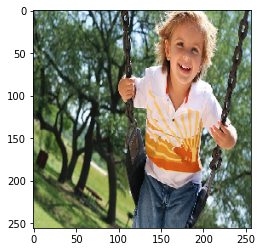

In [98]:
plt.imshow(test_img);

In [99]:
final_sentence

'a man is in'

## Evaluating the results

In [71]:
with open('../raw_data/text/Flickr8k.token.txt') as token_file:
    lines = token_file.readlines()
image_tags = []
captions = []
for line in range(0,len(lines)):
    image_tags.append(lines[line].split('#')[0])
    captions.append(((lines[line].split('#')[1]).split('\t')[1]).split(' .')[0])

In [100]:
captions[image_tags.index(test_img_tag)]

'a blonde boy in a white and orange t-shirt is playing on a swing'

In [115]:
y_pred = final_sentence.split()
y_true = captions[image_tags.index(test_img_tag)].split()

### Bilingual Evaluation Understudy Score

In [116]:
from nltk.translate.bleu_score import sentence_bleu

In [117]:
score = sentence_bleu(y_true, y_pred)
print(float(score))

1.2882297539194154e-231
